<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

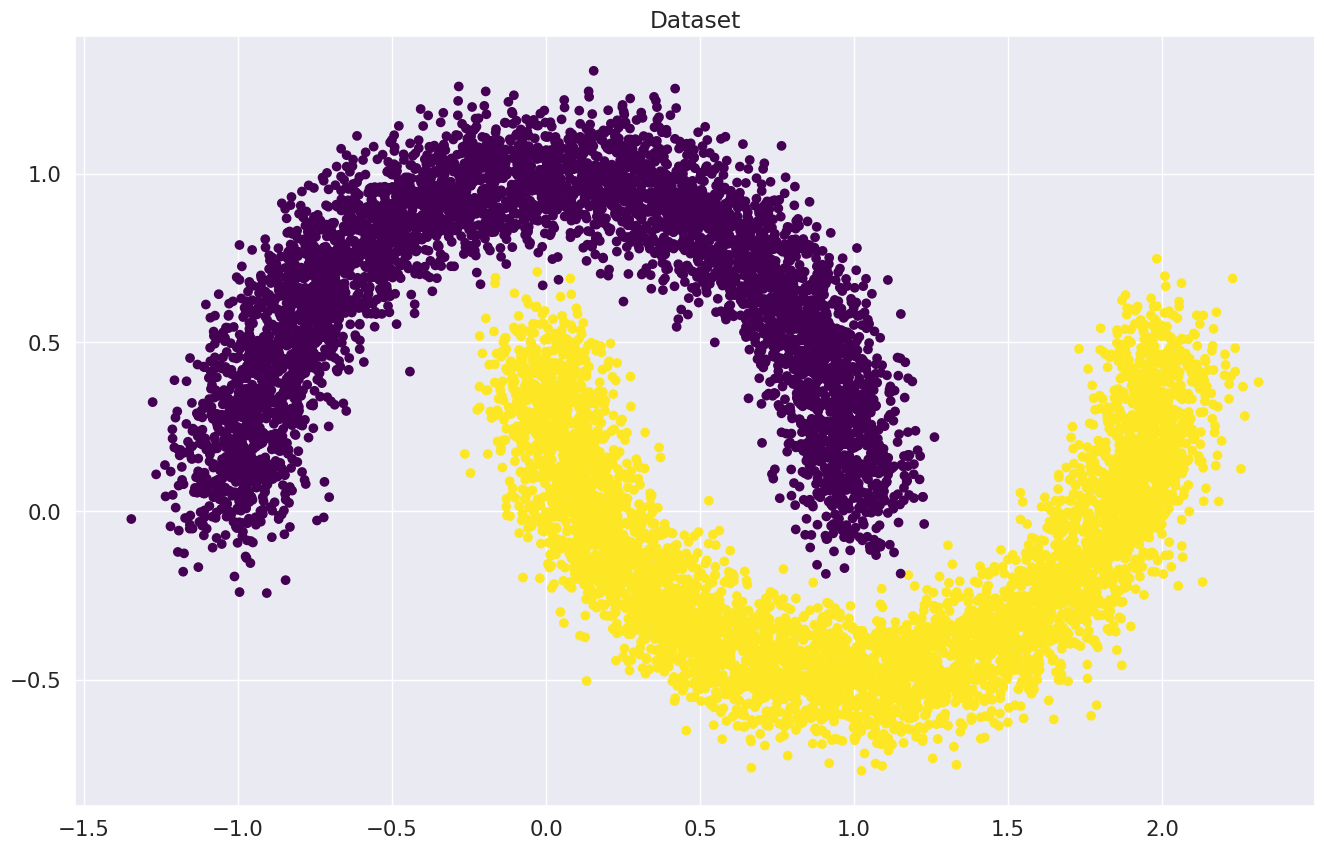

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [5]:
X_train

array([[ 0.50202001, -0.33758011],
       [-0.02001968,  0.239079  ],
       [ 0.57026061,  0.81166576],
       ...,
       [ 0.32163146, -0.35671524],
       [ 2.01344205,  0.03227946],
       [ 0.17908235,  0.93097468]])

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train).view(-1, 1)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val).view(-1, 1)

In [7]:
X_val_t.dtype # check

torch.float32

Создаем `Dataset` и `DataLoader`.

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if self.bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))
        #else:
            #self.bias_term = None

    def forward(self, x):
        x = torch.mm(x, self.weights.t())
        if self.bias:
            x += self.bias_term
        return x

In [10]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [11]:
linear_regression.weights

Parameter containing:
tensor([[-0.2712, -0.5112]], requires_grad=True)

In [12]:
linear_regression.bias

True

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [13]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(linear_regression)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
|  weights  |     2      |
| bias_term |     1      |
+-----------+------------+
Total Trainable Params: 3


3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [14]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) # using linear_regression to get outputs from x_batches
        loss = loss_function(outp, y_batch) # computing loss
        loss.backward()
        losses.append(loss.detach().flatten()[0]) # flatten to 1D + append in yhe list
        optimizer.step()
        probabilities = torch.sigmoid(outp) # using sigmoid func
        preds = (probabilities > 0.5).type(torch.long) # self.long() is equivalent to self.to(torch.int64)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 66.0
Iteration: 100
Batch accuracy: 64.09375
Iteration: 200
Batch accuracy: 64.46875
Iteration: 300
Batch accuracy: 65.09375
Iteration: 400
Batch accuracy: 64.046875
Iteration: 500
Batch accuracy: 64.0625
Iteration: 600
Batch accuracy: 65.875
Iteration: 700
Batch accuracy: 63.875

Iteration: 700.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 700 iterations

### Визуализируем результаты

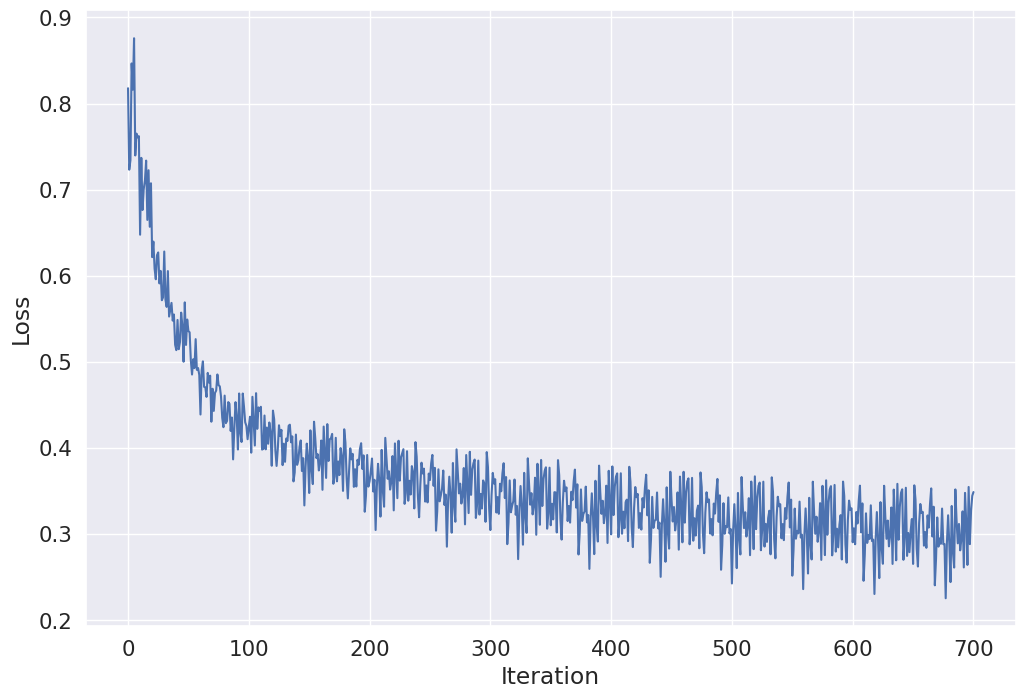

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

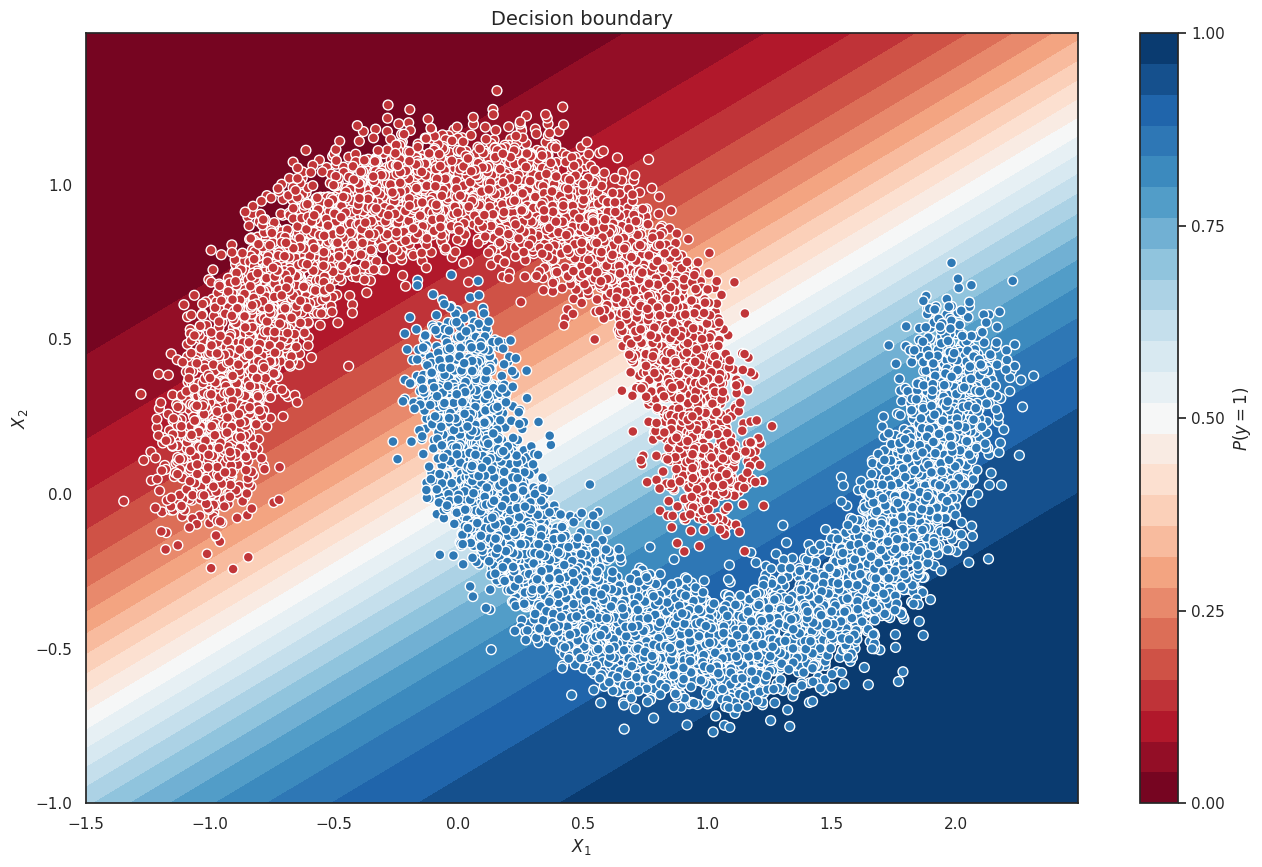

In [16]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [17]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        probabilities = torch.sigmoid(model(x_batch)) #YOUR CODE. Compute predictions
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [18]:
predict(val_dataloader,linear_regression).shape[0]

2500

In [19]:
y_val_t.shape[0]

2500

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val_t, predict(val_dataloader,linear_regression)).round(2)

0.86

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.86

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [21]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [22]:
for data in train_dataloader:
    print(data)
    break

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1.,

Получили тензоры, соответствующие 64 изображениям и меткам их классов (размер батча - 64).

---



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [23]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [24]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)


In [25]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [27]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9022333333333333
Loader: valid. Accuracy: 0.9473
Epoch: 2
Loader: train. Accuracy: 0.9538166666666666
Loader: valid. Accuracy: 0.9554
Epoch: 3
Loader: train. Accuracy: 0.96705
Loader: valid. Accuracy: 0.9706
Epoch: 4
Loader: train. Accuracy: 0.9735166666666667
Loader: valid. Accuracy: 0.9692
Epoch: 5
Loader: train. Accuracy: 0.9763666666666667
Loader: valid. Accuracy: 0.9711
Epoch: 6
Loader: train. Accuracy: 0.9803
Loader: valid. Accuracy: 0.9571
Epoch: 7
Loader: train. Accuracy: 0.9822166666666666
Loader: valid. Accuracy: 0.9754
Epoch: 8
Loader: train. Accuracy: 0.9834333333333334
Loader: valid. Accuracy: 0.971
Epoch: 9
Loader: train. Accuracy: 0.9863333333333333
Loader: valid. Accuracy: 0.9773
Epoch: 10
Loader: train. Accuracy: 0.98685
Loader: valid. Accuracy: 0.9771


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [28]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.9473, 0.9554, 0.9706, 0.9692, 0.9711, 0.9571, 0.9754, 0.971, 0.9773, 0.9771]

In [29]:
class ModelMNIST(nn.Module):
    def __init__(self):
        super(ModelMNIST, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            activation,
            nn.Linear(128, 128),
            activation,
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

In [30]:
model = ModelMNIST().to(device)

In [31]:
def test_activation_function(activation):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device))
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.to(device))
                preds = outp.argmax(-1)
                correct = (preds == y_batch.to(device)).sum()
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch.to(device))
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [32]:
print('------------------No activation accuracy------------------')
plain_accuracy = test_activation_function(Identical)
print('------------------ReLU activation accuracy------------------')
relu_accuracy = test_activation_function(nn.ReLU)
print('------------------LeakyReLU activation accuracy------------------')
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

------------------No activation accuracy------------------
Epoch: 1
Loader: train. Accuracy: 0.90135
Loader: valid. Accuracy: 0.9452
Epoch: 2
Loader: train. Accuracy: 0.95505
Loader: valid. Accuracy: 0.9636
Epoch: 3
Loader: train. Accuracy: 0.9676833333333333
Loader: valid. Accuracy: 0.9734
Epoch: 4
Loader: train. Accuracy: 0.9744833333333334
Loader: valid. Accuracy: 0.9685
Epoch: 5
Loader: train. Accuracy: 0.9776166666666667
Loader: valid. Accuracy: 0.9745
Epoch: 6
Loader: train. Accuracy: 0.9791833333333333
Loader: valid. Accuracy: 0.9755
Epoch: 7
Loader: train. Accuracy: 0.9830166666666666
Loader: valid. Accuracy: 0.9684
Epoch: 8
Loader: train. Accuracy: 0.9842833333333333
Loader: valid. Accuracy: 0.9757
Epoch: 9
Loader: train. Accuracy: 0.9861166666666666
Loader: valid. Accuracy: 0.9769
Epoch: 10
Loader: train. Accuracy: 0.9875666666666667
Loader: valid. Accuracy: 0.9777
------------------ReLU activation accuracy------------------
Epoch: 1
Loader: train. Accuracy: 0.986933333333333

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

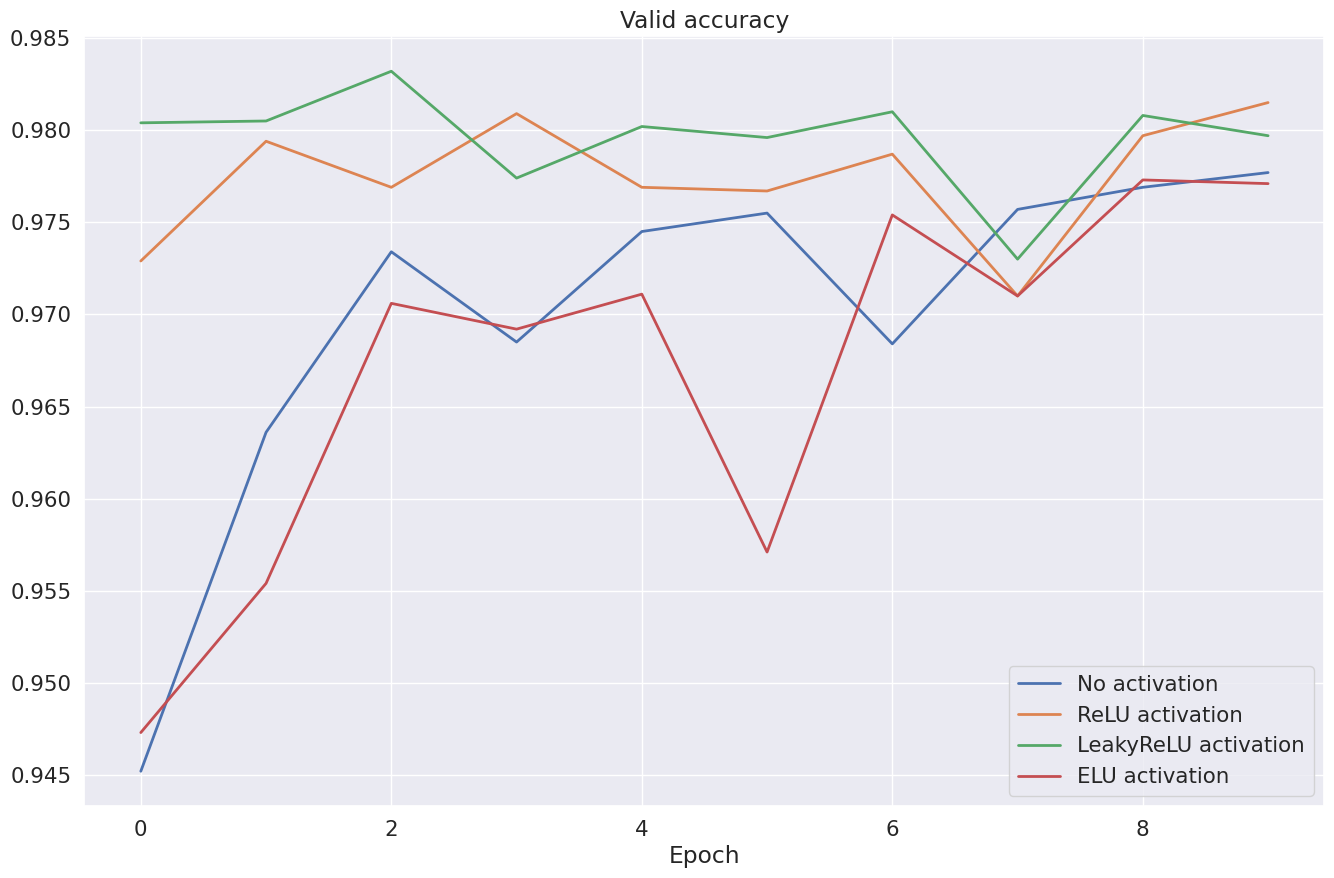

In [33]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

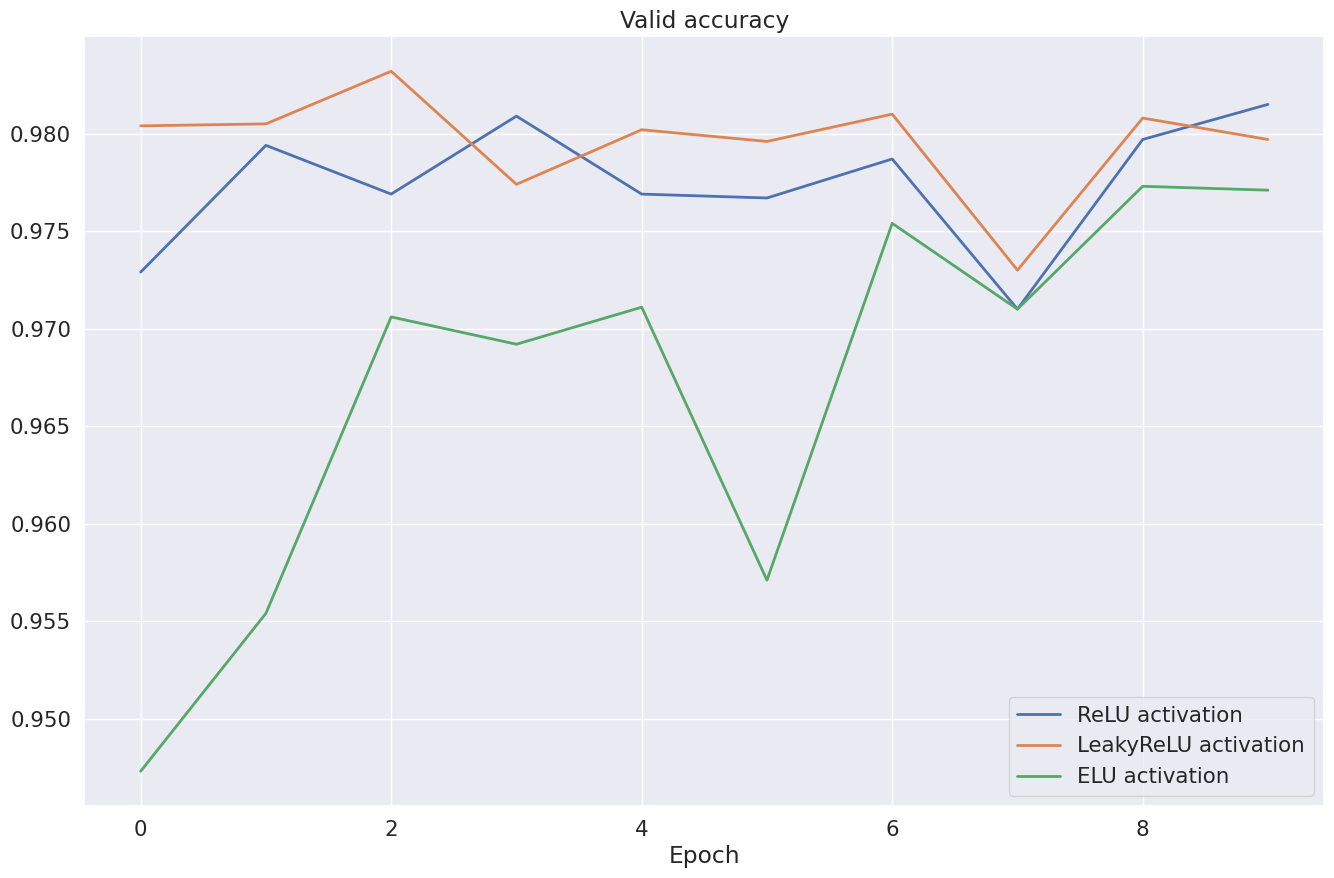

In [34]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [35]:
print(f"Identical Mean Valid Accuracy: {np.mean(plain_accuracy)}")
print(f"ReLU Mean Valid Accuracy: {np.mean(relu_accuracy)}")
print(f"Leaky_ReLU Mean Valid Accuracy: {np.mean(leaky_relu_accuracy)}")
print(f"ELU Mean Valid Accuracy: {np.mean(elu_accuracy)}")

Identical Mean Valid Accuracy: 0.96994
ReLU Mean Valid Accuracy: 0.97746
Leaky_ReLU Mean Valid Accuracy: 0.97958
ELU Mean Valid Accuracy: 0.96715


In [36]:
print(max(relu_accuracy))
print(max(leaky_relu_accuracy))

0.9815
0.9832


In [49]:
print(relu_accuracy[8])
print(leaky_relu_accuracy[8])

0.9797
0.9808


**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

1. На последней эпохе обучения вперед вырвалась ReLU, однако, начиная с 5 эпохи до 9 включительно, Leaky_ReLU показывала более выскоие результаты, чем классическая ReLU.
2. При этом, в целом, максимальный результат, достигнут Leaky_ReLU на 3 эпохе обучения.
3. Известно, что Leaky ReLU более устойчива к "умиранию" нейронов за счет того, что не зануляет отрицательные значения, а возвращает линейную функцию от входа, умноженную на небольшой коэффициент, называемый отрицательным уклоном (leak). Видимо, на большей части эпох нек. значимая часть нейронов имела отрицательное значение, и их вклад оказался существенным, чтобы "обогнать" ReLU.
---
Для большей уверенности целесообразно провести обучение на большем количестве эпох.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [37]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-04-01 13:43:15--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   159KB/s    in 0.3s    

2024-04-01 13:43:15 (159 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



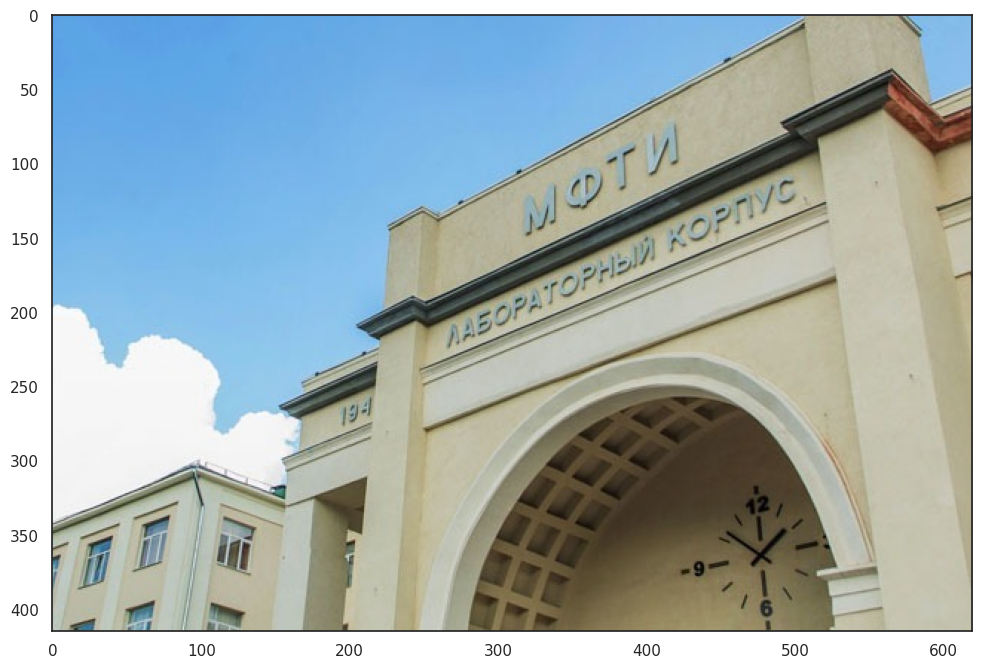

In [38]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [39]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, -1, 0],
    [1, -1, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

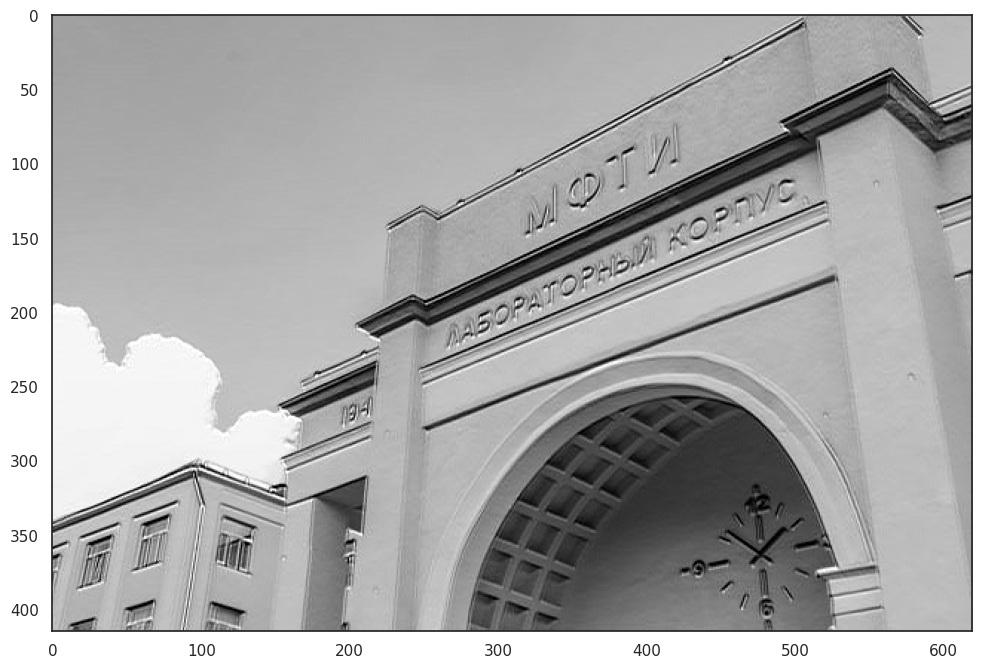

In [40]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

1) Е;
2) Д;
3) А;
4) B;
5) Б;
6) Г.

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [41]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #x = torch.flatten(x)
        #print(x.shape)
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [42]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [43]:
summary(model, (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [44]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch.to(device))
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9151
Loader: valid. Accuracy: 0.9686
Epoch: 2
Loader: train. Accuracy: 0.9751833333333333
Loader: valid. Accuracy: 0.9798
Epoch: 3
Loader: train. Accuracy: 0.9822833333333333
Loader: valid. Accuracy: 0.9847
Epoch: 4
Loader: train. Accuracy: 0.9861333333333333
Loader: valid. Accuracy: 0.9842
Epoch: 5
Loader: train. Accuracy: 0.98855
Loader: valid. Accuracy: 0.9858
Epoch: 6
Loader: train. Accuracy: 0.9902
Loader: valid. Accuracy: 0.9859
Epoch: 7
Loader: train. Accuracy: 0.9918
Loader: valid. Accuracy: 0.9845
Epoch: 8
Loader: train. Accuracy: 0.9930166666666667
Loader: valid. Accuracy: 0.986
Epoch: 9
Loader: train. Accuracy: 0.9938166666666667
Loader: valid. Accuracy: 0.9876
Epoch: 10
Loader: train. Accuracy: 0.9948333333333333
Loader: valid. Accuracy: 0.9884


In [45]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

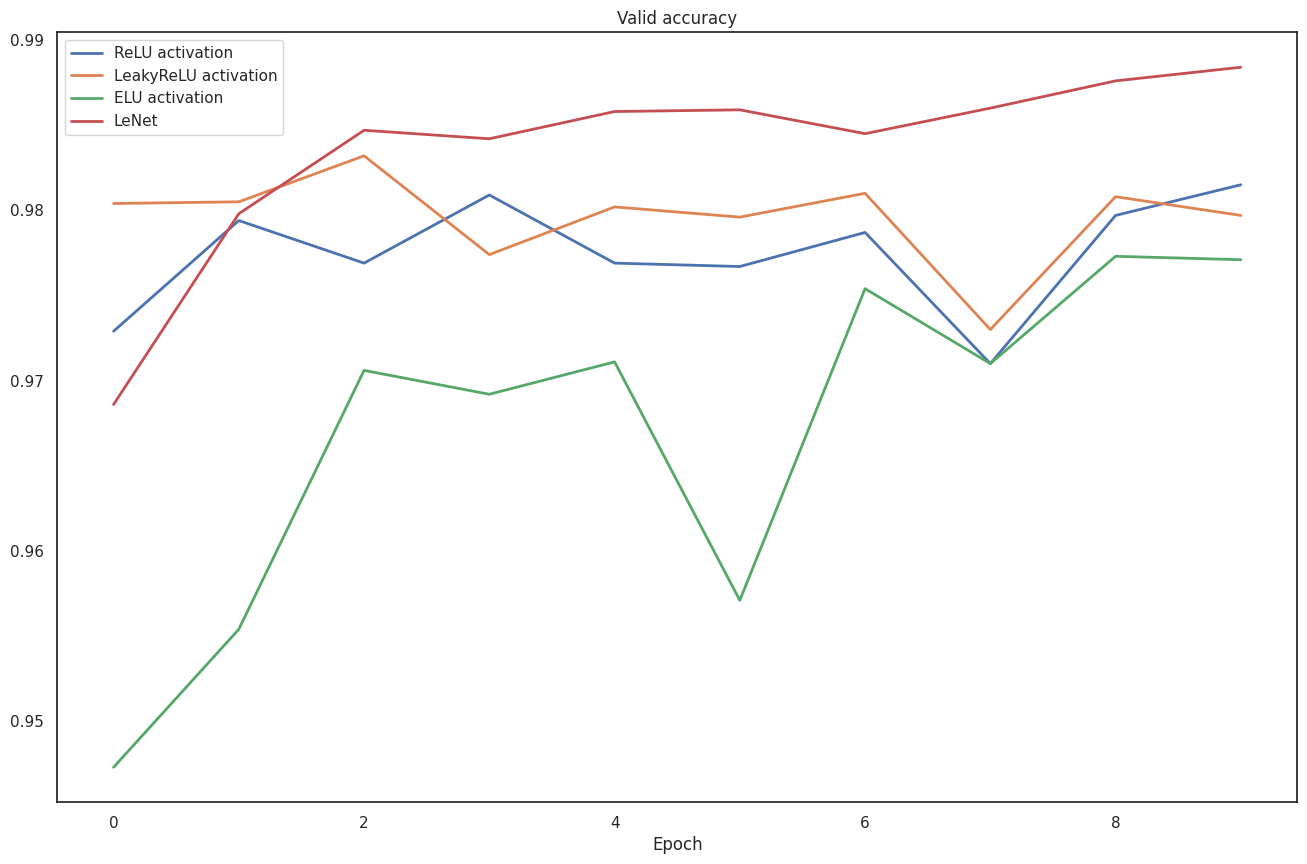

In [46]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**0.99

In [47]:
"accuracy: {:0.2f}".format(lenet_accuracy[-1])

'accuracy: 0.99'